# Arrival Time Prediction - Pre Processing
This notebook is the first on the work on GP regression for arrival time prediction and deals with the pre processing before a model can be trained to make predictions.

First off lets get some libraries into scope and load the data.

In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime

data = pd.read_csv('../../bus203_all.csv')
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
0,0,2018-02-16T04:48:40.0000000+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,NaN,1,1
1,1,2018-02-16T04:48:40.0000000+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1
2,2,2018-02-16T04:48:40.0000000+01:00,ArrivedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,Rydsv\xe4gens \xe4ndh\xe5llpl.,1,1
3,3,2018-02-16T04:48:41.0000000+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1
4,4,2018-02-16T04:48:42.0000000+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1


The names in the csv are very verbose, so we'll shorten them. This is of course a matter of preference but I prefer it this way.

In [2]:
data = data.rename(columns = {
                        'latitude': 'lat', 
                        'longitude': 'lon', 
                        'journey_number': 'traj', 
                        'segment_number': 'seg', 
                        'speed': 'speed', 
                        't': 't'})
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,lon,lat,direction,speed,station,traj,seg
0,0,2018-02-16T04:48:40.0000000+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,NaN,1,1
1,1,2018-02-16T04:48:40.0000000+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1
2,2,2018-02-16T04:48:40.0000000+01:00,ArrivedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,Rydsv\xe4gens \xe4ndh\xe5llpl.,1,1
3,3,2018-02-16T04:48:41.0000000+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1
4,4,2018-02-16T04:48:42.0000000+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1


The goal is to estimate arrival time given a coordinate, but to do that we first need to annotate the trajectories in the data with the actual arrival times. The chunk below will process the data to extract the time until next stop and put that into the file "data.pkl" which can then be loaded into a data frame. Consequently this snippet only needs to be run if we want to change the data. This took me 20 minutes and the resulting file is a 4gb pickle file that contains less info than the 1 gb csv file.

In [3]:
def parse_time(dt_str):
    dt, _, _ = dt_str.partition(".")
    return datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")
   
t0 = time.time()
data_to_process = data # data.loc[data['journey_number'] == 1]
ts = pd.DataFrame(np.zeros(data_to_process.size), columns=list('t'))

# Annotate data with time until arrival
last_stop_timestamp = datetime.utcnow()
for i, d in reversed(list(data_to_process.iterrows())):
    t = parse_time(d['timestamp'])
    if d['event'] == 'EnteredEvent':
        last_stop_timestamp = t
    else:
         ts.iloc[i] = (last_stop_timestamp - t).seconds
            
elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")

gp_df = pd.concat([
            data_to_process['timestamp'],
            data_to_process['lat'], 
            data_to_process['lon'], 
            data_to_process['traj'], 
            data_to_process['seg'], 
            data_to_process['speed'], 
            ts],
            axis = 1)



Data processed in 1050.0075178146362  seconds


There are many times where busses stop or drive very slowly. This causes a lot of data points to be clustered which will make future processing harder. To prevent this we will filter out data points in every trajectory that are too close by some delta. Worth noting is that coordinates are not in euclidian space but on a spherical surface so pythagoras theorem is no good here and we have to turn to haversine distance.

In [4]:
from math import sin, cos, sqrt, asin

def haversine(lat1, lon1, lat2, lon2):
    R = 6378.1370                # radius in KM
    p = 0.017453292519943295;    # pi / 180
    dLat = p*(lat2 - lat1)
    dLon = p*(lon2 - lon1)
    lat1 = p*(lat1)
    lat2 = p*(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return R * c

def as_dict(d):
    return {
        'timestamp': d.timestamp,
        'lat': d.lat,
        'lon': d.lon,
        'seg': d.seg,
        'speed': d.speed,
        't': d.t,
        'traj': d.traj
    }

t0 = time.time()

# Iterate through all data points, compare with latest 
# in resampled_data and append if it the distance is larger than 
# haversine delta. Delta is from testing different values on seg 1 
# and chosing the largest-ish one that did not remove visible points.
delta = 6e-5 # approx. 4 metres, taken from Linus master thesis
rows = [as_dict(gp_df.iloc[0])]
for i, d in gp_df.iterrows():
    di = rows[len(rows)-1]
    if haversine(d.lat, d.lon, di.get('lat'), di.get('lon')) > delta:
        rows.append(as_dict(d))

resampled_data = pd.DataFrame(rows)

elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")

MemoryError: 

Plotting the data show one outlier, how it got there is beyond me. I have not taken additional actions to sanitise the data further based on this observation, which would be a good thing to do.

In [4]:
import pandas as pd
resampled_data = pd.read_pickle('data.pkl')
resampled_data[resampled_data.seg == 1]

,lat,lon,seg,speed,t,traj
0,15.571015,58.414238,1.0,-1.00,72.0,1.0
1,15.571012,58.414246,1.0,0.00,71.0,1.0
2,15.571008,58.414249,1.0,0.00,70.0,1.0
3,15.571004,58.414257,1.0,0.00,69.0,1.0
4,15.571006,58.414257,1.0,0.00,68.0,1.0
5,15.571008,58.414261,1.0,0.00,67.0,1.0
6,15.571010,58.414261,1.0,0.00,66.0,1.0
7,15.571012,58.414261,1.0,0.00,65.0,1.0
8,15.571014,58.414265,1.0,0.00,64.0,1.0
9,15.571015,58.414268,1.0,0.00,63.0,1.0


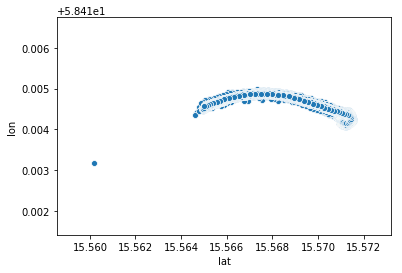

In [6]:
import seaborn as sns
seg = resampled_data[resampled_data.seg == 1]
sns.scatterplot(x="lat", y="lon", data=seg)

Finally let's pickle the data into a test and training set so it can be loaded with pickle.

In [37]:
n_trajs = int(resampled_data.traj.max())
n_train = round(n_trajs*0.8)
train_ixs = np.random.randint(0, n_trajs-1, n_train)

train_trajs = resampled_data[resampled_data.traj.transform(lambda x: x in train_ixs)]
test_trajs = resampled_data[resampled_data.traj.transform(lambda x: x not in train_ixs)]
train_trajs.to_pickle('train.pkl')
test_trajs.to_pickle('test.pkl')